In [1]:
# lets make NB distributions of expression

# testing ideas
from scipy.stats import nbinom
import matplotlib.pyplot as plt
import numpy as np
import random

import anndata as ad
import pandas as pd
from scipy.sparse import coo_matrix, csc_matrix

In [2]:
# how many samples to generate
patients_to_generate = 2000
genes_to_generate = 2000

# for now, theta will be simple, both batch 1 and batch 2 will have the same parameters
# will likely make this more complex in the future
theta_pull_dist_1 = theta_pull_dist_2 = 1 # will try 1, 2, etc


# balance between batches
# do not set to 0 or 1 (will have to fix this)
batch_balance = 0.5

### DEG PARAMETERS ###
effect_size = 0.5  # Reduce expression by 50% for DEGs in treatment group
percent_degs = 0.1 # % of genes that are selected to be DEGs
percent_affected = 0.1 # % of patients that are selected to have a reduced mu (mu * (1-effect_size)); only for DEG genes


# other parameters
# whether or not to draw distributions when generating simulated genes
# note that there's no limitations to this; if you're creating 10000 genes it'll draw 10000 plots
draw_NB_data = False

# Create gene-gene and/or sample-sample edges by duplicating rows/columns (with a small amount of added variation
copy_neighbors = False

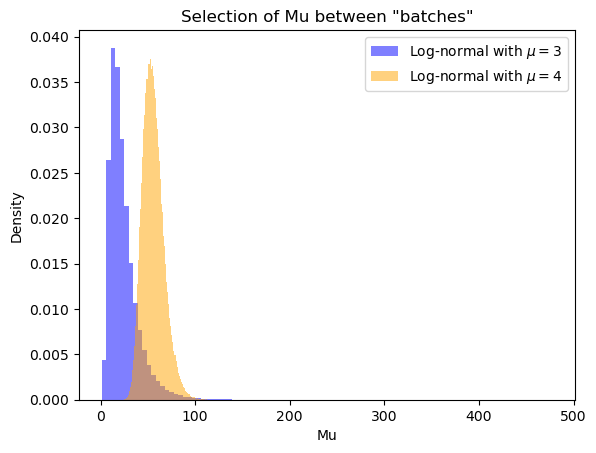

In [3]:
# In this version of the code, I want to create a distribution to "pull" our NB Mu parameters from
# we discussed log-normal
mu_pull_dist_1 = 3
mu_pull_dist_2 = 4


sigma1 = 0.6  # standard deviation of the logarithm of the batch 1 distribution
sigma2 = 0.2  # standard deviation of the logarithm of the batch 2 distribution

# Generate a sample from the log-normal distribution
# Generate samples for both distributions
sample_size = patients_to_generate*100 # multiplication ensures a varied number of possible values
samples1 = np.random.lognormal(mean=mu_pull_dist_1, sigma=sigma1, size=sample_size)
samples2 = np.random.lognormal(mean=mu_pull_dist_2, sigma=sigma2, size=sample_size)

samples1_rounded = np.round(samples1, 6)
samples2_rounded = np.round(samples2, 6)

# Plotting the samples
plt.hist(samples1_rounded, bins=100, density=True, alpha=0.5, color='blue', label=f'Log-normal with $\mu={mu_pull_dist_1}$')
plt.hist(samples2_rounded, bins=100, density=True, alpha=0.5, color='orange', label=f'Log-normal with $\mu={mu_pull_dist_2}$')
plt.title('Selection of Mu between "batches"')
plt.xlabel('Mu')
plt.ylabel('Density')
# plt.xscale('log')
plt.legend()
plt.show()

In [4]:
# choosing which genes will be the DEGs
DEG_indices = np.random.choice(range(genes_to_generate), size=int(percent_degs * genes_to_generate), replace=False)  

# we will want to add something to Obs which will be a clinical parameter that will trend with the DEGs
# one categorical (literally whether )
PAT_indices_train = np.random.choice(range(patients_to_generate), size=int(percent_affected * patients_to_generate), replace=False)  
PAT_indices_valid = np.random.choice(range(patients_to_generate), size=int(percent_affected * patients_to_generate), replace=False)  
# we want which patients get reduced to be different between train and validation

In [5]:
# Container for simulated data
train_data, valid_data, gene_names = [], [], []
gene_mu1, gene_var1, gene_mu2, gene_var2 = [], [], [], []
gene_a_deg = []

# we have to sample from both log normals outside of the loop so that we can ensure replacement
sampled_mus_batch1 = np.random.choice(samples1_rounded, size=genes_to_generate, replace=False)
sampled_mus_batch2 = np.random.choice(samples2_rounded, size=genes_to_generate, replace=False)


# Bernouli trial idea didn't work out
# This way, all samples will get the same mu, not a partial amount
samples_indices = np.random.binomial(n=1, p=batch_balance, size=patients_to_generate)

for i in range(genes_to_generate):
    # so we compute the p and n parameters for each batch using their respective Mu/thetas
    mu_batch1 = sampled_mus_batch1[i]
    var_batch1 = mu_batch1 + (mu_batch1**2 / theta_pull_dist_1)
    n_batch1 = mu_batch1**2 / (var_batch1 - mu_batch1)
    p_batch1 = n_batch1 / (n_batch1 + mu_batch1)

    mu_batch2 = sampled_mus_batch2[i]
    var_batch2 = mu_batch2 + (mu_batch2**2 / theta_pull_dist_2)
    n_batch2 = mu_batch2**2 / (var_batch2 - mu_batch2)
    p_batch2 = n_batch2 / (n_batch2 + mu_batch2)

    # we then sample M (patients) values from both NBs
    counts_batch1 = nbinom.rvs(n_batch1, p_batch1, size=patients_to_generate)
    counts_batch2 = nbinom.rvs(n_batch2, p_batch2, size=patients_to_generate)

    # implement the DEG effect here
    if i in DEG_indices:
        mu_batch1 = sampled_mus_batch1[i] * (1 - effect_size)
        var_batch1 = mu_batch1 + (mu_batch1**2 / theta_pull_dist_1)
        n_batch1 = mu_batch1**2 / (var_batch1 - mu_batch1)
        p_batch1 = n_batch1 / (n_batch1 + mu_batch1)

        mu_batch2 = sampled_mus_batch2[i] * (1 - effect_size)
        var_batch2 = mu_batch2 + (mu_batch2**2 / theta_pull_dist_2)
        n_batch2 = mu_batch2**2 / (var_batch2 - mu_batch2)
        p_batch2 = n_batch2 / (n_batch2 + mu_batch2)

        counts_batch1_deg = nbinom.rvs(n_batch1, p_batch1, size=patients_to_generate)
        counts_batch2_deg = nbinom.rvs(n_batch2, p_batch2, size=patients_to_generate)

        counts_batch1[PAT_indices_train] = counts_batch1_deg[PAT_indices_train]
        counts_batch2[PAT_indices_train] = counts_batch2_deg[PAT_indices_train]

        gene_a_deg.append(True)
    else:
        gene_a_deg.append(False)


    # and we use the Bernouli to select from which NB distribution do we take values from
    selected_data_train = np.where(samples_indices == 0, counts_batch1, counts_batch2)
    
    # append it to a list of gene expression values
    train_data.append(selected_data_train)  

    # repeat for validation
    counts_batch3 = nbinom.rvs(n_batch1, p_batch1, size=patients_to_generate)
    counts_batch4 = nbinom.rvs(n_batch2, p_batch2, size=patients_to_generate)

    if i in DEG_indices:
        counts_batch3_deg = nbinom.rvs(n_batch1, p_batch1, size=patients_to_generate)
        counts_batch4_deg = nbinom.rvs(n_batch2, p_batch2, size=patients_to_generate)

        counts_batch3[PAT_indices_valid] = counts_batch3_deg[PAT_indices_valid]
        counts_batch4[PAT_indices_valid] = counts_batch4_deg[PAT_indices_valid]

    # and we use the Bernouli to select from which NB distribution do we take values from
    selected_data_val = np.where(samples_indices == 0, counts_batch3, counts_batch4)
    
    # append it to a list of gene expression values
    valid_data.append(selected_data_val)  

    # Saving Mus/Thetas; to be placed in the AnnData 'var' table
    gene_mu1.append(mu_batch1)
    gene_var1.append(theta_pull_dist_1)
    gene_mu2.append(mu_batch2)
    gene_var2.append(theta_pull_dist_2)

    # Creating a unique gene name
    gene_name = "Gene_" + str(i + 1)
    gene_names.append(gene_name)

    # draw expression selected out if desired
    title = "Expression for Gene " + str(i + 1)

    if (draw_NB_data is True):
        plt.hist(selected_data_train, bins=50, color="blue")
        plt.xlabel("Expression")
        plt.ylabel("Frequency")
        plt.title(title)
        plt.show()

        


In [6]:
# create "clinical" variables for the patients in 
pat_adjusted_cat_train, pat_adjusted_cont_train = [], []
pat_adjusted_cat_valid, pat_adjusted_cont_valid = [], []

for i in range(patients_to_generate):
      if i in PAT_indices_train:
            pat_adjusted_cat_train.append('Yes')
            pat_adjusted_cont_train.append(np.random.uniform(1, 10))
      else:
            pat_adjusted_cat_train.append('No')
            pat_adjusted_cont_train.append(np.random.uniform(6, 15))
      
      if i in PAT_indices_valid:
            pat_adjusted_cat_valid.append('Yes')
            pat_adjusted_cont_valid.append(np.random.uniform(1, 10))
      else:
            pat_adjusted_cat_valid.append('No')
            pat_adjusted_cont_valid.append(np.random.uniform(6, 15))

In [ ]:
# So now we have to save these results as an AnnData table with batch in the obs
# training data

# append genes into a single matrix, and transpose so rows are samples and not rows
all_counts = np.array(train_data)
counts_in_anndata_orientation = np.transpose(all_counts)

adata = ad.AnnData(X=counts_in_anndata_orientation, var=pd.DataFrame(index=gene_names), dtype=np.int64)

# make batch labels
#batch_labels = ['1'] * size_batch1 + ['2'] * size_batch2  # Adjust according to your data structure
adata.obs['batch'] = samples_indices
adata.obs['cat_clinic'] = pat_adjusted_cat_train
adata.obs['cont_clinic'] = pat_adjusted_cont_train

# add gene names to var
adata.var['gene'] = gene_names
adata.var['mu_batch1'] = gene_mu1
adata.var['theta_batch1'] = gene_var1
adata.var['mu_batch2'] = gene_mu2
adata.var['theta_batch2'] = gene_var2
adata.var['deg'] = gene_a_deg

# and lets save the data
file_path = '/path/to/output/simulated_simple_' + str(patients_to_generate) + '_' + str(genes_to_generate) + '_theta_' + str(theta_pull_dist_1) + '_batch_balance_' + str(batch_balance) + '.degs_' + str(effect_size) + "_" + str(percent_degs) + "_" + str(percent_affected) + '.train.tau_1.h5ad'

# Save the AnnData object
adata.write(file_path)


/home/UWO/emucaki/miniconda3/envs/ffpe_env_gpu/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [ ]:
# repeat for validation data
all_counts = np.array(valid_data)
counts_in_anndata_orientation = np.transpose(all_counts)

adata_val = ad.AnnData(X=counts_in_anndata_orientation, var=pd.DataFrame(index=gene_names), dtype=np.int64)

# make batch labels
#batch_labels = ['1'] * size_batch1 + ['2'] * size_batch2  # Adjust according to your data structure
adata_val.obs['batch'] = samples_indices

# add gene names to var
adata_val.var['gene'] = gene_names
adata_val.var['mu_batch1'] = gene_mu1
adata_val.var['theta_batch1'] = gene_var1
adata_val.var['mu_batch2'] = gene_mu2
adata_val.var['theta_batch2'] = gene_var2

# and lets save the data
file_path = '/path/to/output/simulated_simple_' + str(patients_to_generate) + '_' + str(genes_to_generate) + '_theta_' + str(theta_pull_dist_1) + '_batch_balance_' + str(batch_balance) + '.degs_' + str(effect_size) + "_" + str(percent_degs) + "_" + str(percent_affected) + '.valid.tau_1.h5ad'

# Save the AnnData object
adata_val.write(file_path)


In [9]:
# checking to see how many sample-sample "edges" were created in this run
#print(np.sum(np.sum(sample_sample_adj)))
for i in range(len(adata.obs.cat_clinic)):
    print(adata.obs.cat_clinic[i])

Yes
No
No
No
No
No
No
No
No
No
No
No
No
No
Yes
No
No
No
No
No
No
No
No
No
No
No
Yes
No
No
No
No
No
No
Yes
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
Yes
No
No
No
Yes
Yes
No
Yes
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
Yes
No
No
Yes
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
Yes
No
Yes
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
Yes
No
No
No
No
No
No
No
No
No
No
No
No
No
No
Yes
No
Yes
No
No
No
No
No
No
Yes
No
Yes
No
No
Yes
Yes
Yes
No
No
No
Yes
No
No
No
Yes
No
No
No
No
Yes
No
Yes
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
Yes
No
No
No
No
No
No
Yes
No
No
No
No
No
No
Yes
No
No
No
No
Yes
No
No
No
No
No
No
No
Yes
No
No
Yes
No
No
No
Yes
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
Yes
Yes
No
No
No
No
No
No
No
Yes
No
Yes
No
No
No
No
No
No
No
Yes
No
No
No
No
No
No
Yes
No
No
No
No
Yes
No
No
No
No
No
No
No
No
No
No
No
No
No
Yes
No
No
No
No
Yes
No
No
Yes
No
No
No
No
No
No
No
No
No
Yes
No
No
No
N

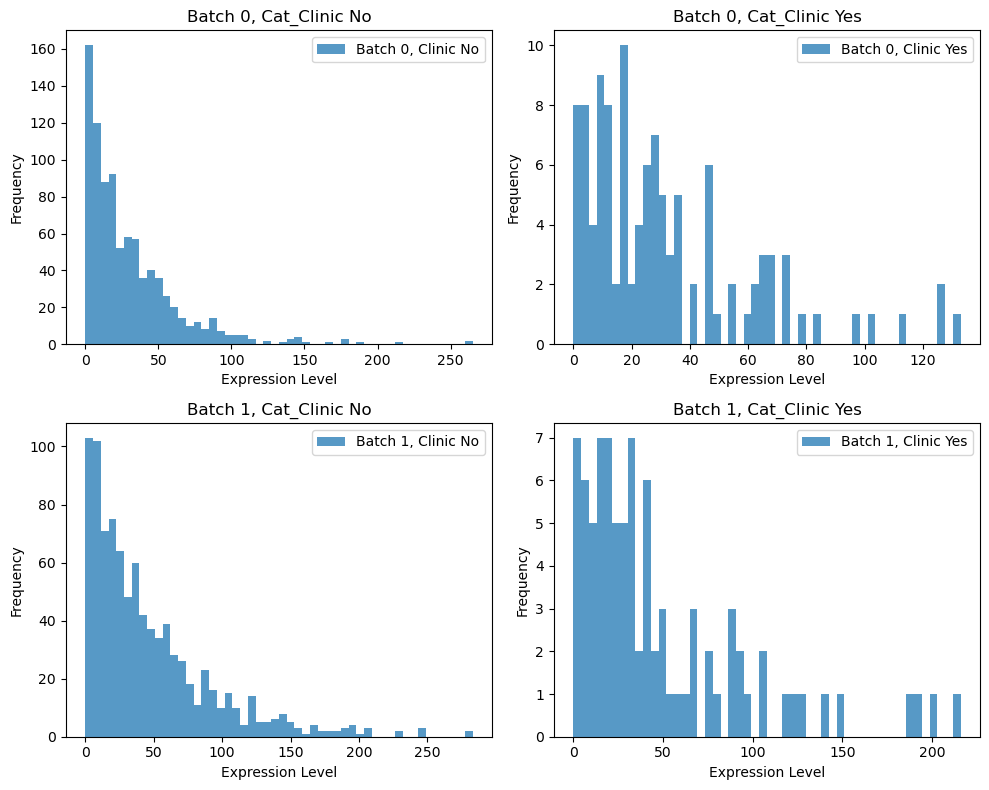

In [12]:
# Lets make a histogram where we split into 4 groups, the two batches and the two "cat_clinics" 

groups = adata.obs.groupby(['batch', 'cat_clinic'])

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))  # Adjust size as necessary
axes = axes.flatten()  # Flatten the array of axes for easy indexing

# Iterate over groups and plot histograms
for i, ((batch, clinic), group) in enumerate(groups):
    # Get indices for the group
    group_indices = group.index

    # Assume we're plotting the first gene for demonstration
    gene_name = adata.var.index[0]  # Adjust to target specific gene or data

    # Extract expression data for the gene
    data_to_plot = adata[group_indices, gene_name].X
    if data_to_plot.ndim > 1:
        data_to_plot = data_to_plot.flatten()  # Flatten if necessary

    # Plot histogram
    axes[i].hist(data_to_plot, bins=50, alpha=0.75, label=f'Batch {batch}, Clinic {clinic}')
    axes[i].set_title(f'Batch {batch}, Cat_Clinic {clinic}')
    axes[i].set_xlabel('Expression Level')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

plt.tight_layout()
plt.show()

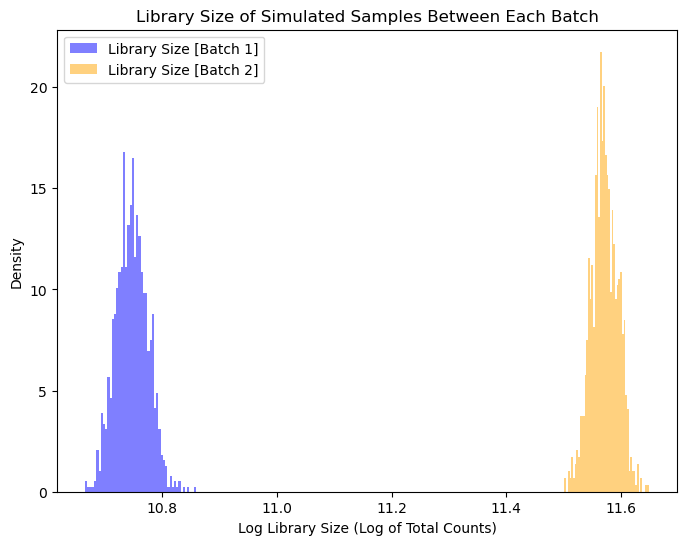

In [11]:
# draw library size information distrubtions
library_sizes = np.log(adata_val.X.sum(axis=1))

batches = adata_val.obs['batch']
library_sizes_batch1 = library_sizes[batches == 0]
library_sizes_batch2 = library_sizes[batches == 1]

# Plotting the samples
#plt.hist(library_sizes, bins=50, density=True, alpha=0.5, color='blue', label=f'Library Size [all samples]')
plt.figure(figsize=(8, 6))
plt.hist(library_sizes_batch1, bins=50, density=True, alpha=0.5, color='blue', label='Library Size [Batch 1]')
plt.hist(library_sizes_batch2, bins=50, density=True, alpha=0.5, color='orange', label='Library Size [Batch 2]')
plt.title('Library Size of Simulated Samples Between Each Batch')
plt.xlabel('Log Library Size (Log of Total Counts)')
plt.ylabel('Density')
# plt.yscale('log')  # Use a log scale for the y-axis
#plt.xscale('log')
plt.legend()
plt.show()

# you can clearly see the difference caused by the two Mus